# Librerías

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import time
import platform
import random
from gcn_model import GCN
from dataset_utils import generate_edge_index, build_graph_from_sample
from training_utils import train, evaluate

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [3]:
# Propiedades del sistema
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda
    print("system_specs", system_specs)


system_specs {'os': 'Windows', 'os_version': '10.0.22000', 'machine': 'AMD64', 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel', 'python_version': '3.12.9', 'device': 'cuda', 'gpu_name': 'NVIDIA GeForce RTX 2060', 'gpu_memory_total_GB': 6.0, 'cuda_version': '12.1'}


In [4]:
dir_path = os.getcwd()
print(dir_path)

c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\Repo_TFG\ia_thermal\ernestoemedina\GCN_MK1


In [5]:
# Ruta del dataset completo
dataset_path = os.path.join(dir_path, "Datasets", "PCB_dataset.pth")
norm_dataset_path = os.path.join(dir_path, "Datasets", "PCB_Dataset_Norm.pth")

# Cargar dataset
dataset = torch.load(dataset_path)
norm_dataset = torch.load(norm_dataset_path)

C:\Users\ramse\AppData\Local\Temp\ipykernel_12760\3411024544.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
C:\Users\ramse\AppData\Lo

## Para desnormalizar

In [11]:
# Cargar la info de normalización
info_path = os.path.join(os.getcwd(), "Datasets", "normalization_info.pth")
norm_info = torch.load(info_path)

max_T_interfaces = norm_info["max_T_interfaces"]
max_Q_heaters = norm_info["max_Q_heaters"]
max_T_env = norm_info["max_T_env"]

## En ppio no debería ser necesario, ya que hemos cargado el dataset sin normalizar

def desnormalize_inputs(dataset_norm, idx):
    T_interfaces_norm = dataset_norm.T_interfaces[idx]
    Q_heaters_norm = dataset_norm.Q_heaters[idx]
    T_env_norm = dataset_norm.T_env[idx]
    
    T_interfaces_real = T_interfaces_norm * max_T_interfaces
    Q_heaters_real = Q_heaters_norm * max_Q_heaters
    T_env_real = T_env_norm * max_T_env
    
    return T_interfaces_real, Q_heaters_real, T_env_real

C:\Users\ramse\AppData\Local\Temp\ipykernel_12760\1878969574.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_info = torch.load(info_path)


In [20]:
idx = 1
T_interfaces_real, Q_heaters_real, T_env_real = desnormalize_inputs(norm_dataset, idx)

# Por ejemplo:
print(torch.max(T_interfaces_real), "K")
print(torch.max(Q_heaters_real), "W")
print(torch.max(T_env_real), "K")


tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [22]:
# Seleccionar un índice para graficar
idx = 1  # Puedes cambiar este valor

# Obtener los valores reales de las CC en T, Q y T_env
T_interfaces_real = dataset.denormalize_T_interfaces(dataset.T_interfaces)
Q_heaters_real = dataset.denormalize_Q_heaters(dataset.Q_heaters)
T_env_real = dataset.denormalize_T_env(dataset.T_env)

print(T_interfaces_real.shape)
print(torch.max(T_interfaces_real[idx]), "K")
print(torch.max(Q_heaters_real[idx]), "W")
print(torch.max(T_env_real[idx]), "K")


torch.Size([10000, 13, 13])
tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [9]:
idx = 10
T_interfaces_norm = norm_dataset.T_interfaces[idx]
Q_heaters_norm = norm_dataset.Q_heaters[idx]
T_env_norm = norm_dataset.T_env[idx]

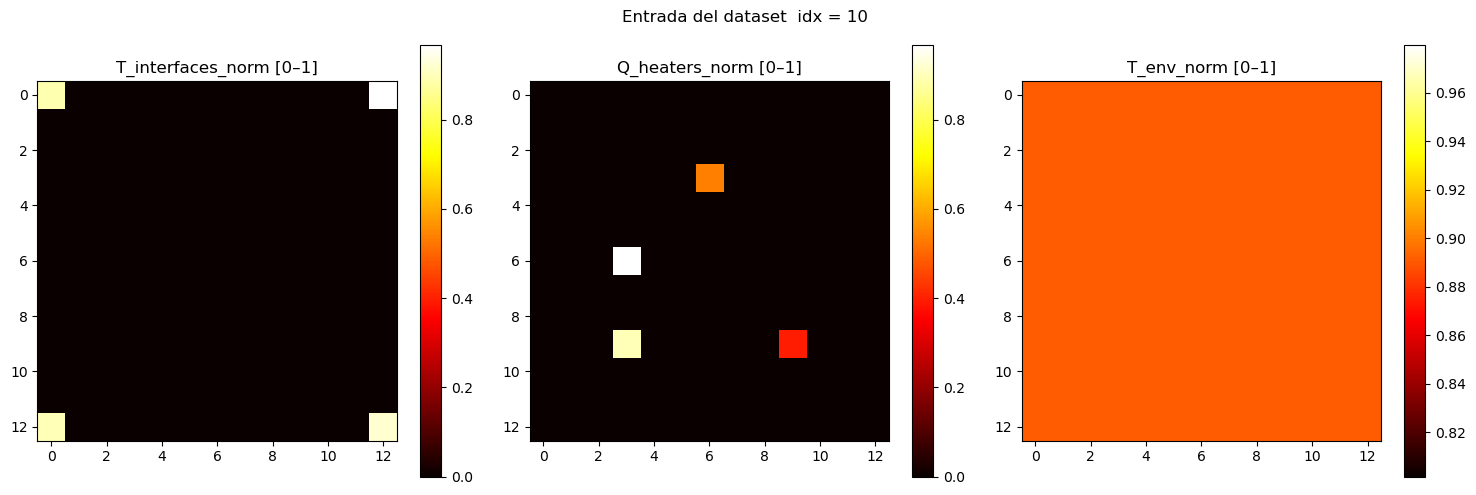

In [10]:
# Crear figura para mostrar las 3 variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(T_interfaces_norm.numpy(), cmap='hot')
axs[0].set_title("T_interfaces_norm [0–1]")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(Q_heaters_norm.numpy(), cmap='hot')
axs[1].set_title("Q_heaters_norm [0–1]")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(T_env_norm.numpy(), cmap='hot')
axs[2].set_title("T_env_norm [0–1]")
plt.colorbar(im3, ax=axs[2])

plt.suptitle(f"Entrada del dataset  idx = {idx}")
plt.tight_layout()
plt.show()

## GCN

### Configuración de la red

In [ ]:
config = {
    "input_dim": 3,           # 3 canales: T_interfaces, Q_heaters, T_env
    "hidden_dim": 64,
    "output_dim": 1,          # por ejemplo, predecir una temperatura por nodo
    "num_layers": 3,
    "batch_size": 32,
    "epochs": 10,
    "use_dropout": True,
    "dropout_rate": 0.2,
    "use_batchnorm": True,
    "use_residual": False
}

In [ ]:
edge_index = generate_edge_index(grid_size=13) # Matriz de adyacencia bidireccional
graphs = build_graph_list(norm_dataset, edge_index)

In [ ]:
# Por si en algún momento el Dataset tuviera un patrón al ser generado
random.seed(42)
random.shuffle(graphs)

### División Dataset

In [ ]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

### Entrenamiento

In [ ]:
# Entrenamiento

print("Iniciando entrenamiento...")

for epoch in range(config["epochs"]):
    train_loss = train(model, train_loader, optimizer, device)
    val_metrics = evaluate(model, val_loader, config, plot=False, verbose=False)

    print(f"Epoch {epoch+1}/{config['epochs']} "
          f"Train Loss: {train_loss:.6f} | "
          f"Val MSE: {val_metrics['mse']:.6f} | "
          f"Val MAE: {val_metrics['mae']:.6f} | "
          f"Max Error: {val_metrics['max_error']:.6f}")

### Evaluación

In [ ]:
evaluate(model, test_loader, config, plot=True)

### Predicción

In [ ]:
from training_utils import load_latest_model, predict

# Cargar el modelo más reciente
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
)

model = load_latest_model(model)

# Predecir sobre test
predicciones = predict(model, test_loader)

print("Predicciones shape:", predicciones.shape)